In [11]:
# Aux
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import normalize 

# Model stuff
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [12]:
# Local imports
from utils import pipeline
from data import gen_lin_data
from models import fit_linear_model
from models import fit_nonlinear_model

In [13]:
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
'''
Parameters to control:
-> data set type
-> model type {linear, nonlinear}
  -> if linear:
    -> if: ensemble
        -> disjoint data split
        -> randomly subsampled data (not disjoint)
    -> else: vanilla model
  -> else: nonlinear vanilla model
-> recourse methods
    -> SCFE
    -> GS
    -> CCHVAE
<<<NOTE: THE SCRIPT ITERATES OVER ALL OF THESE>>>
-> attack methods
    -> vanilla loss attack
    -> LRT loss attack {SOTA}
    -> CFD attack {our suggestion}
    -> CFD LRT {our suggestion}
'''

params = {
    'experiment': 'synthetic',                                      # options: {'synthetic', 'realworld'}
    'datasets': ['mnist', 'heloc', 'default', 'housing'],           # options: {'churn', 'mnist', 'heloc', 'default', 'housing'}
    'fit_sgd': False,                                               # boolean: whether linear model should be fitted with sgd
    'linear': True,                                                 # boolean: whether linear or nonlinear model should be fitted
    'hidden_layers': [100] * 1,                                     # list with ints: size of hidden layers (for nonlinear model)
    'epochs': 750,                                                  # int: number epochs (for nonlinear model)
    'batch_size': 32,                                               # int: batch size (for nonlinear model)
    'epsd': 1e-5,                                                   # pos real: constant to ensure stable loss evaluations
    'weighting': 'global',                                          # options: {'global', 'local'}: whether global variance or 1/n_shadow_models variance
    'n_shadow_models': 5,                                           # int: number of shadow models
    'frac': 0.75,                                                   # frac: fraction of samples used for resampling scheme within shadow model train pipeline
    'penalty': 'none',                                              # options: {'none', 'l1', 'l2'}: reguralizer for underlying model
    'C': 1000,                                                      # pos real: regularization strength: higher leads less regularized models
    'ensemble': True,                                               # boolean: whether to fit an underlying ensemble model
    'n_ensemble': 250,                                              # int: number of ensemble models
    'frac_ensemble': 0.75,                                          # pos real in [0,1]: fraction of samples used for resampling to train ensemble model
    'disjoint': True,                                               # boolean: Whether disjoint data sets should be used for training private ensemble
    'n_splits': 3,                                                  # int: Number of disjoint ensembles
    'lr_scfe': 0.005,                                               # pos. real in [0,1]:Learning rate for SCFE gradient descent
    'max_iter': 1000,                                               # int: max number of iterations for SCFE gradient descent
    'methods': 'scfe',                                              # options: {'scfe', 'cchvae', 'gs'}: Recourse method type
    'quantile': 0.97                                                # pos real in [0,1]: quantile to be used for quantile-based thresholds
}

In [15]:
# Parameters to control the synthetic data generating process described above
synth_gauss = {
    'n': 5000,                             # n_train -> 2500
    'd': [50, 250, 1500, 1800, 3000],      # data dimensions
    'sigma2': 1,                           # data variance
    'frac_important_features': 0.1,        # fraction of relevant features
    'sigma2_eps': 0.01,                    # label noise
    'corr': 0.0,                           # correlation between features
}

**DATA GENERATING PROCESS**

Denote by $\gamma$ the class threshold. 

Denote by $q_{\mathbf{x}_{\alpha}}$ the $100 \times \alpha$-th quantile of the vector $\mathbf{x}$.

Measurement error:
$$ \varepsilon \sim \mathcal{N}(0, \sigma^2_{\varepsilon}) $$
Design matrix: $$ \mathbf{X} \sim \mathcal{N}(\mu_d, \Sigma_d) $$
True coefficient vectors:
$$ \beta_0 \sim U[-1,1]^d$$
$$ \beta = \beta_0 \odot \mathbb{I}_d(|\beta_0| > q_{|\beta_{\alpha}|})$$
$$ \beta = \frac{\beta}{||\beta||_2} $$
Labels:
$$ score =  X \beta + \varepsilon $$
$$ p = \frac{1}{1+\exp(-score)} $$
$$ y =  \mathbb{I}\big( p  > \gamma \big) $$

Signal-to-noise ratio: $$ \frac{||\beta||_2}{\sigma^2_{\varepsilon}} = \frac{1}{\sigma^2_{\varepsilon}}$$ 
We fix the true weight vector to unit length to make sure that we keep a constant signal-to-noise ratio despite an increase in the feature dimension.


**CLASSIFIER**

For now we will train logistic regression classifiers without regulariziation

**DISTANCE using INPUT SPACE COUNTERFACTUAL ACTIONS**

- Target score in logit space: $s$
- Estimated weight of linear model: $\mathbf{w}$. Note that this is a **funtion of the training data**.
- Logit score: $f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} = \log \frac{P(y=1|x)}{1-P(y=1|x)} $
- $\ell_2$ distance to target logit score: $\mathbf{\delta}_x = \frac{s-f(\mathbf{x})}{||\mathbf{w}||_2^2} \mathbf{w}$

- When the decision boundary threshold is set to $\xi=0  \Leftarrow \Rightarrow \gamma=0.5$ and $s=0$, then the above distance formula boils down to the standard formula that measures the 'distance to the decision boundary'
- **Note that the only factor that differs across train and test instances is $f(\mathbf{x})$**

**DISTANCE using LATENT SPACE COUNTERFACTUAL ACTIONS**

- We solve: $$\delta_z = argmin_{\delta_z'} \bigg( s-f\big(g(\mathbf{z}+\delta_z')\big) \bigg)^2 + \lambda \cdot ||\delta_z'||_2^2 $$ for the case when: 
  - $f$: logit score from logistic regression classifier
  - $g$: decoder obtained through principal component analysis (PCA); for PCA, the encoder is the inverse of $g$
  
 In this case we can still obtain a closed-form solution, and let's see what insights we can learn from this. Note that the corresponding counterfactual in input space is given by:
 $$  \mathbf{x}_{\text{CF}} = g(\mathbf{z}+\delta_z) \text{ where } \mathbf{z} = g^{-1}(\mathbf{x})  $$
 
To be more concrete, we will assume the folling data generating process:
\begin{align*}
    \mathbf{x} &= g(\mathbf{z}) + \mathbf{r}_x \\
        &= W \mathbf{z} + \mathbf{r}_x. \\
\end{align*}
This two things:
- we use $k \leq d$ dimensions to construct our latent space; only the $k$ latent dimensions are used to for counterfactual search.
-  If $k = d$, then the reconstruction error will be $\mathbf{r}_x=\mathbf{0}$.

Now, we have everything in place to solve the above objective:

$$ \delta_z = argmin_{\delta_z'} \bigg( s-f\big(g(\mathbf{z}+\delta_z') + \mathbf{r}_x\big) \bigg)^2 + \lambda \cdot ||\delta_z'||_2^2 $$
$$ \delta_z = argmin_{\delta_z'} \bigg( s- \theta^\top \big(W \mathbf{z}+\delta_z' + \mathbf{r}_x\big) \bigg)^2 + \lambda \cdot ||\delta_z'||_2^2 $$
$$ \delta_z = argmin_{\delta_z'} \bigg( s- \theta^\top \mathbf{x} - \theta^\top W\delta_z' \bigg)^2 + \lambda \cdot ||\delta_z'||_2^2 $$
$$ \delta_z = argmin_{\delta_z'} \bigg( m - \theta^\top W \delta_z' \bigg)^2 + \lambda \cdot ||\delta_z'||_2^2 $$

This problem is solved by:
$$ \delta_z = \frac{m}{\lambda + ||\tilde{\theta}||_2^2} \tilde{\theta} ~~ \text{where} ~~ m=s-\theta^\top \mathbf{x}, \tilde{\theta} = \theta^\top W$$

Finally, the action measured in input space is given by (for $\lambda \to 0$):
$$ \delta_x = W \delta_z  = W  \frac{s - f(\mathbf{x})}{||\tilde{\theta}||_2^2} \tilde{\theta} $$.

Note that $W$ and $\tilde{\theta}$ are constant across training and test points. So, again, **the only factor that differs across train and test instances is $f(\mathbf{x})$.**


In [16]:
def remove_colls(df, corr_threshold: float = 0.8):
    # Drop multicollinear features
    # Create correlation matrix
    corr_matrix = df.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find features with correlation greater than corr_threshold
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    # Drop features 
    df = df.drop(to_drop, axis=1).astype(float)
    return df

In [17]:
def experiment(params, synth_gauss):

    scores = {
        'dists_train': [],              # DISTANCES
        'dists_test': [],
        'dists_latent_train': [],
        'dists_latent_test': [],
        'dists_lrt_train_local': [],
        'dists_lrt_test_local': [],
        'dists_lrt_train_global': [],
        'dists_lrt_test_global': [],
        'dists_train_quantile':[], 
        'dists_test_quantile':[],
        'losses_train': [],             # LOSSES
        'losses_test': [],
        'stable_losses_train': [],
        'stable_losses_test': [],
        'losses_lrt_train_local': [],
        'losses_lrt_test_local': [],
        'losses_lrt_train_global': [],
        'losses_lrt_test_global': [],
        'preds_train': [],              # PREDICTIONS
        'preds_test': [],
        'preds_lrt_train_local': [],
        'preds_lrt_test_local': [], 
        'preds_lrt_train_global': [],
        'preds_lrt_test_global': []
    }

    if params['experiment'] == 'realworld':
        #####################
        ###   LAOD DATA   ###
        #####################
        
        '''
        Below the data is not only loaded but also cleaned. 
        We remove columns that lead to multicollinearity problems in linear models.
        After the data is loaded and cleaned, we normalize and split the data into 
        three equal folds. The third fold is usually not necessary, but we used it for
        the quantile strategy (not in the paper). To be consistent across all experiments
        we then applied this splitting strategy across all datasets.
        '''
        
        for dataname in params['datasets']:
            print(f'Computing results on: {dataname}')
            if dataname == 'communities':
                df = pd.read_csv(f'data/{dataname}.csv', header=None)
                df = df.drop_duplicates()
                df = df.replace('?', np.nan)
                df = df.drop(columns=[0, 1, 2, 3, 4, 101, 102, 103, 104, 105, 106, 107, 
                                      108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 
                                      118, 119, 120, 121, 122, 123, 124, 126])
                df = df.dropna().astype(float)
                Y = df[127].values 
                Y = (Y > np.median(Y)) * 1
                df = df.drop(columns=[127])
                df = remove_colls(df, corr_threshold=0.90)

            elif dataname == 'housing':
                df = pd.read_csv(f'data/{dataname}.csv')
                df = df.drop_duplicates()
                df = df.replace('?', np.nan)
                df = df.dropna()
                Y = df['median_house_value'].values 
                Y = (Y > np.median(Y))
                df = df.drop(columns=['median_house_value'])
                df['ocean_proximity'] = df['ocean_proximity'].replace(['NEAR BAY', 'ISLAND', 'NEAR OCEAN', '<1H OCEAN', 'INLAND'], 
                                                                      [0, 0, 0, 1, 2])
                df = df.astype(float)

            elif dataname == "heloc":
                df = pd.read_csv(f'data/{dataname}.csv')
                df = df.drop_duplicates()
                df = df.replace('?', np.nan)
                df = df.dropna()
                df = df.drop(columns=['RiskPerformance'])
                df = df.dropna()
                Y = df['ExternalRiskEstimate'].values 
                Y = (Y >= np.median(Y)) * 1
                df = df.drop(columns=['ExternalRiskEstimate'])
                df = df.astype(float)

            elif dataname == 'default':
                df = pd.read_csv(f'data/{dataname}.csv', header=None)
                df = df.drop_duplicates()
                df = df.replace('?', np.nan)
                df = df.dropna()
                ind_nondefault = np.where(df.values[:,-1] == 0)[0]
                n_default = ind_nondefault.shape[0]
                ind_default = np.where(df.values[:,-1] > 0)[0]
                ind_nondefault_subset = np.random.choice(ind_nondefault, ind_default.shape[0], replace=False)
                inds = np.r_[ind_default, ind_nondefault_subset]
                df = df.iloc[inds]
                Y = (df.values[:,-1] >= np.median(df.values[:,-1])) * 1
                df = df.drop(columns=df.columns[-1])
                df = df.astype(float)
                df = remove_colls(df, corr_threshold=0.95)

            elif dataname == 'mnist':
                df_train = pd.read_csv(f'data/{dataname}_train.csv')
                df_test = pd.read_csv(f'data/{dataname}_test.csv')
                df = pd.concat([ df_train,  df_test], ignore_index=True)
                y0_ind = np.where(df['label']==3)[0]
                y1_ind = np.where(df['label']==8)[0]
                df['label'] = df['label'].map({3:0, 8:1})
                inds = np.r_[y0_ind , y1_ind]
                df = df.iloc[inds]
                Y = (df['label'].values) * 1
                df = df.drop(columns=['label'])
                df = remove_colls(df, corr_threshold=0.95)

            elif dataname == 'churn':
                df = pd.read_csv(f'data/{dataname}.csv', header=None)
                df = df.drop_duplicates()
                df = df.replace('?', np.nan)
                df[230] = df[230].map({-1:0, 1:1})
                ind_nondefault = np.where(df.values[:,-1] == 0)[0]
                n_default = ind_nondefault.shape[0]
                ind_default = np.where(df.values[:,-1] > 0)[0]
                ind_nondefault_subset = np.random.choice(ind_nondefault, ind_default.shape[0], replace=False)
                inds = np.r_[ind_default, ind_nondefault_subset]
                df = df.iloc[inds]
                Y = df[230].values
                df = df.drop(columns=[230])
                df = df.iloc[:,0:190]         # keep numerical features only
                df = df.fillna(df.median())   # fill missing with median
                cols = df.columns[df.isna().any()].tolist()
                df = df.drop(columns=cols)
                df = df.dropna()

            # standardize data
            scaler = StandardScaler()
            X = df.values.astype(float)
            scaler.fit(X)
            X = scaler.transform(X)
            # normalize data rowwise by ell 2 norm
            X = normalize(X)

            # split data
            X_train, X_t, Y_train, Y_t = train_test_split(X, 
                                                          Y.astype(float), 
                                                          test_size=0.6666667,
                                                          random_state=10)

            # Make sure 1/3 is hold out data
            X_test, X_prime, Y_test, Y_prime = train_test_split(X_t, 
                                                                Y_t,
                                                                test_size=0.5,
                                                                random_state=11)


            n_train = X_train.shape[0]
            n_test = X_test.shape[0]

            ######################
            ###    FIT MODEL   ###
            ######################

            clf = fit_linear_model(X_train, X_test, Y_train, Y_test, params)

            ######################
            ###     SCORES     ###
            ######################

            scores = pipeline(clf, X_train, X_test, X_prime, Y_train, Y_test, Y_prime, scores, params)

    else:
            #####################
            ### GENERATE DATA ###
            #####################
        for i in synth_gauss['d']:

            print(f'Computing for dimension: {i}')
            X, Y = gen_lin_data(d=i, synth_gauss=synth_gauss)


            # split data
            X_train, X_place, Y_train, Y_place = train_test_split(X, 
                                                                  Y, 
                                                                  test_size=0.666667,
                                                                  random_state=10)
            X_test, X_prime, Y_test, Y_prime = train_test_split(X_place, 
                                                                Y_place, 
                                                                test_size=0.5,
                                                                random_state=11)

            n_train = X_train.shape[0]
            n_test = X_test.shape[0]

            ######################
            ###    FIT MODEL   ###
            ######################
            if params['linear']:
                clf = fit_linear_model(X_train, X_test, Y_train, Y_test, params)
            else:
                clf = fit_nonlinear_model(X_train, X_test, Y_train, Y_test, params)
            ######################
            ###     SCORES     ###
            ######################
            scores = pipeline(clf, X_train, X_test, X_prime, Y_train, Y_test, Y_prime, scores, params)
    return scores

# Attack Overview

Below we plot results for a variety of different attacks:
- Simple Loss attack (Yeom et al (2018)) -> Threshold on the loss
- One sided LRT loss attack (Carlini et al (2021)) -> Train shadow models & adjust the loss statistic

Our proposed attacks are:
- Counterfactual distance attack
- Counterfactual distance LRT attack
- **New**: Counterfactual distance + quantile adjustment

The following attack is based on the above observation that the model becomes overconfident on training points (see histograms above). This is also the underlying mechanism for why the distance attack works.

- **New**: Prediction score (i.e., $ \log \frac{P(y=1|x)}{1-P(y=1|x)}$ ) attack
- **New**: Prediction score LRT attack (i.e., $| \log \frac{P(y=1|x)}{1-P(y=1|x)}|$ )

In [18]:
def compute_curve(train_scores: list, test_scores: list, pos_label=1):
    '''
    Given scores for train and test:
    Ouput: tprs and fprs
    '''    
    y = np.r_[np.ones(np.shape(train_scores)[0]), np.zeros(np.shape(test_scores)[0])]
    fs, ts, thresholds = metrics.roc_curve(y, np.r_[train_scores, test_scores], pos_label=pos_label)
    return ts, fs

In [19]:
def plots(scores_train, scores_test, synth_gauss, params, title, bins_train=100, bins_test=100, label=1):
    '''
    Given scores for train and test:
    Ouput: plots of log scaled AUC curves & distributions of stats
    '''
    plot_type = params['experiment']
    
    if plot_type == 'realworld':
        n_params = params['datasets']
    else:
        n_params = synth_gauss['d']

    fig, axs = plt.subplots(1, 1 + len(n_params), figsize=(21, 3))
    
    # COMPUTE AUC CURVE
    all_tprs = []
    all_fprs = []
    
    for i in range(len(n_params)):
        tprs, fprs = compute_curve(scores_train[i], scores_test[i], label)
        all_tprs.append(tprs)
        all_fprs.append(fprs)
    
    for it, d in enumerate(n_params):
        auc = np.round_(metrics.auc(all_fprs[it], all_tprs[it]), 2)
        if plot_type == 'synthetic':
            lab = str(d)
            axs[0].loglog(all_fprs[it], all_tprs[it], label=f"d={lab} - auc:{auc}")
        else:
            axs[0].loglog(all_fprs[it], all_tprs[it], label=f"{d} - auc:{auc}")
            
    axs[0].plot([0,1], [0,1], label='Random Baseline', linestyle='dotted', color='black')
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_xlim([0.001, 1.01])
    axs[0].set_ylim([0.001, 1.01])
    axs[0].set_title(title)
    axs[0].legend(framealpha=0.25)

    # COMPUTE DISTRIBUTION HISTOGRAMS
    for i in range(len(n_params)):
        if plot_type == 'synthetic':
            dim = n_params[i]
            n_train = scores_train[i].shape[0]
            eta = np.round(n_train / synth_gauss['d'][i], 2)
            print(f'(# train samples: {n_train}) / (dimension: {dim}) = eta: {eta}')
        axs[1+i].hist(scores_train[i], alpha=0.25, label='train', bins=bins_train, density=True)
        axs[1+i].hist(scores_test[i], alpha=0.25, label='test', bins=bins_test, density=True)
        axs[1+i].set_xlabel('Scores')
        axs[1+i].set_yscale('log')
        if plot_type == 'synthetic':
            axs[1+i].set_title(f'$\eta$ = {eta}')
        else:
            axs[1+i].set_title(f'{n_params[i]}')
        axs[1+i].legend()
    
    plt.tight_layout()
    n_shadow = params['n_shadow_models']
    n_ens = params['n_ensemble']
    dataset = params['experiment']
    plt.savefig(f'experiments/{title}_{dataset}_nshadow{n_shadow}_nensemble{n_ens}.jpg')

GENERATE RESULTS FOR: 5 SHADOW MODELS & 20 ENSEMBLE MODELS
Computing for dimension: 50
Number of training samples: 2500
training set accuracy on last ensemble model: 1.0
test set accuracy across all models: 0.7597180563887223
Computing for dimension: 250
Number of training samples: 2500
training set accuracy on last ensemble model: 1.0
test set accuracy across all models: 0.6244151169766047
Computing for dimension: 1500
Number of training samples: 2500
training set accuracy on last ensemble model: 1.0
test set accuracy across all models: 0.5488302339532094
Computing for dimension: 1800
Number of training samples: 2500
training set accuracy on last ensemble model: 1.0
test set accuracy across all models: 0.5461307738452311
Computing for dimension: 3000
Number of training samples: 2500
training set accuracy on last ensemble model: 1.0
test set accuracy across all models: 0.5363827234553089
(# train samples: 1666) / (dimension: 50) = eta: 33.32
(# train samples: 1666) / (dimension: 250) =

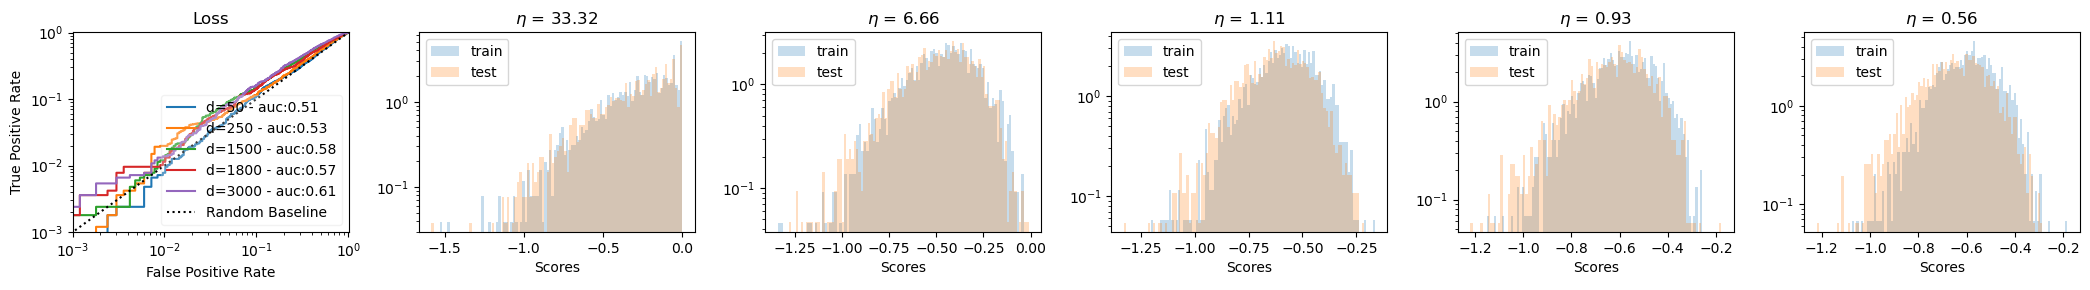

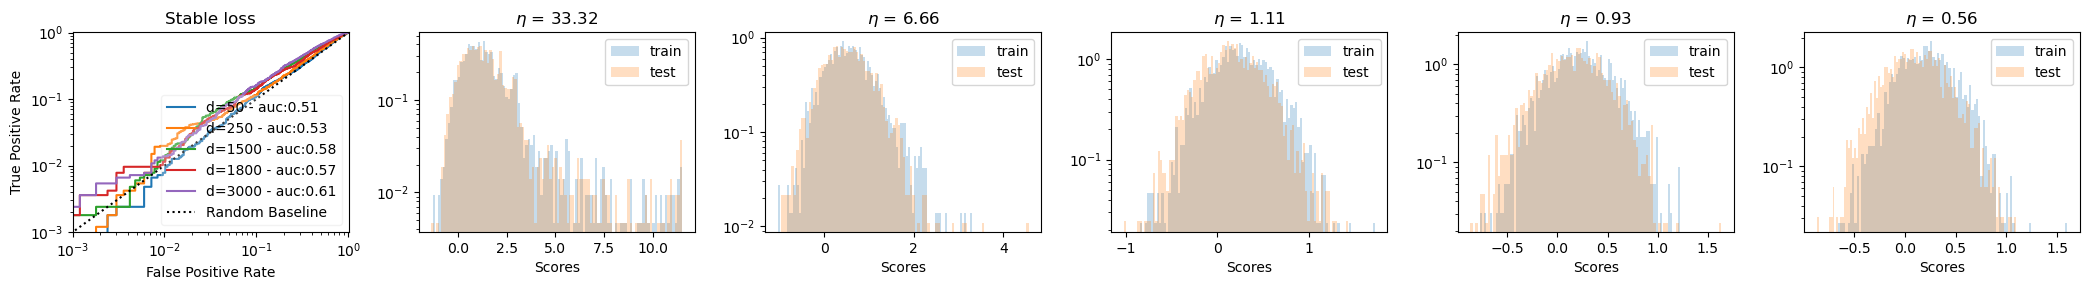

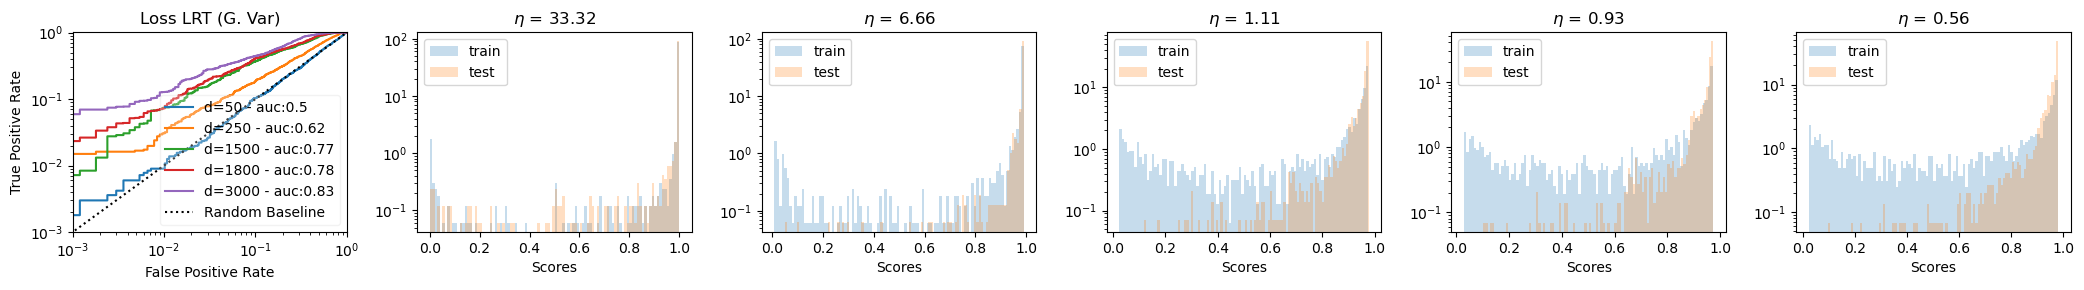

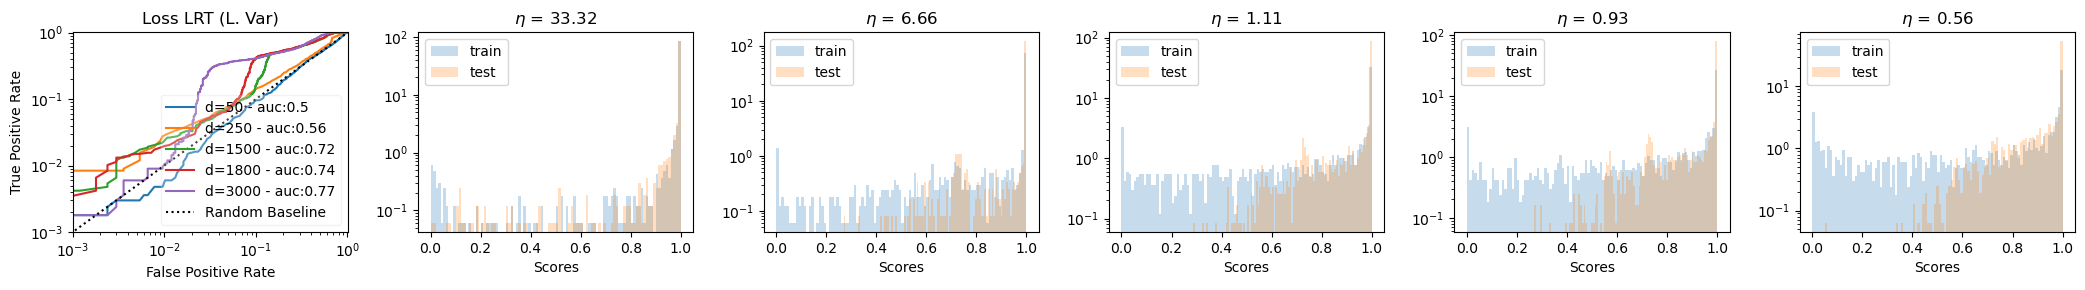

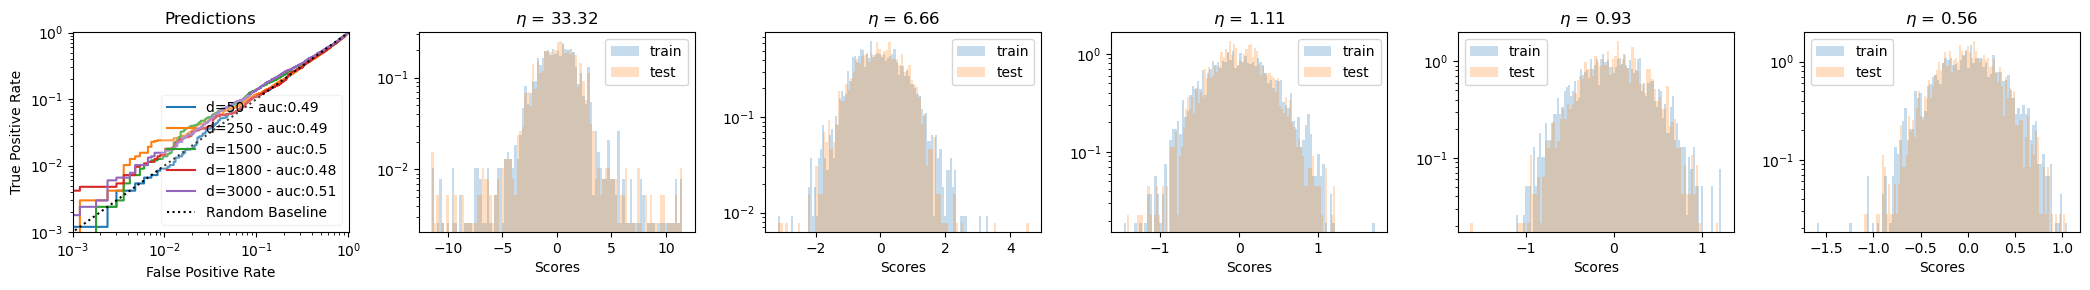

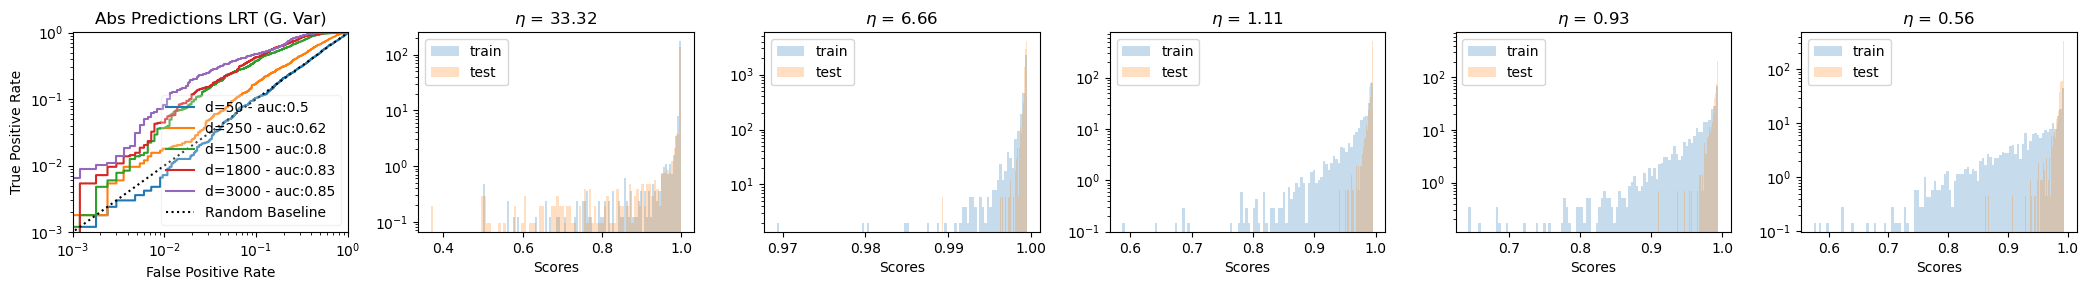

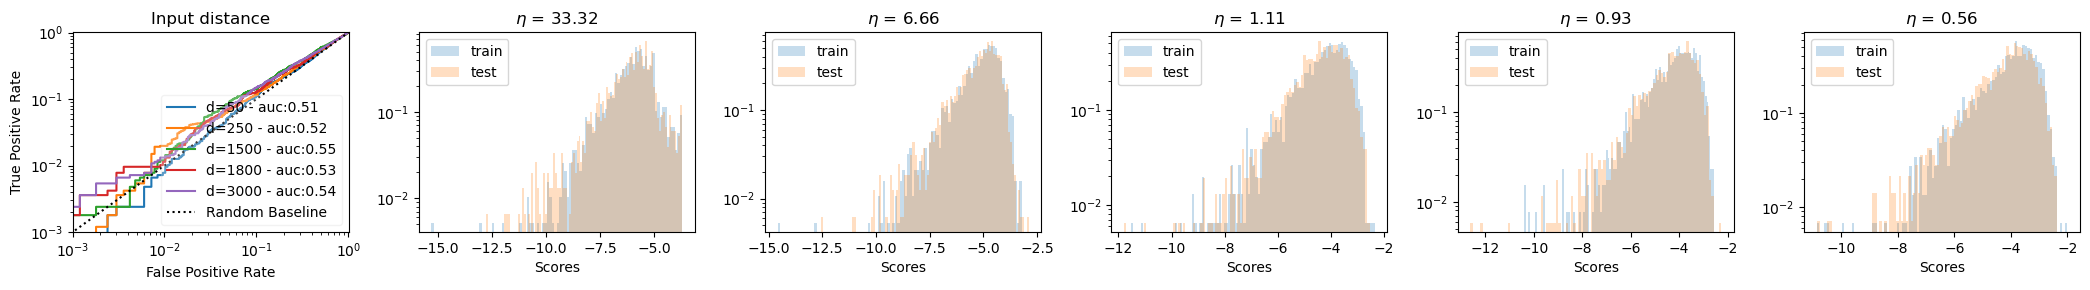

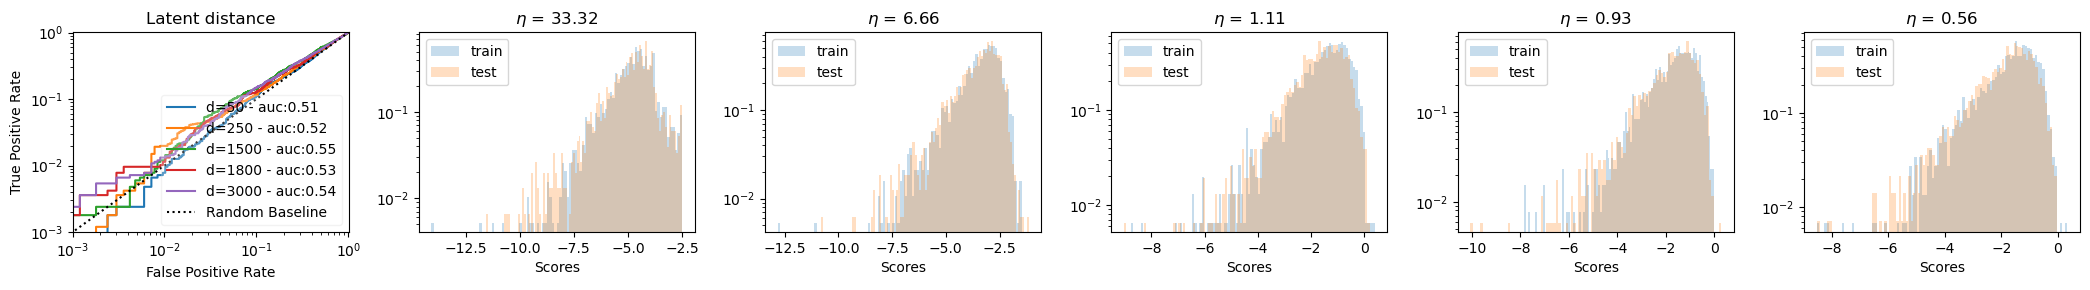

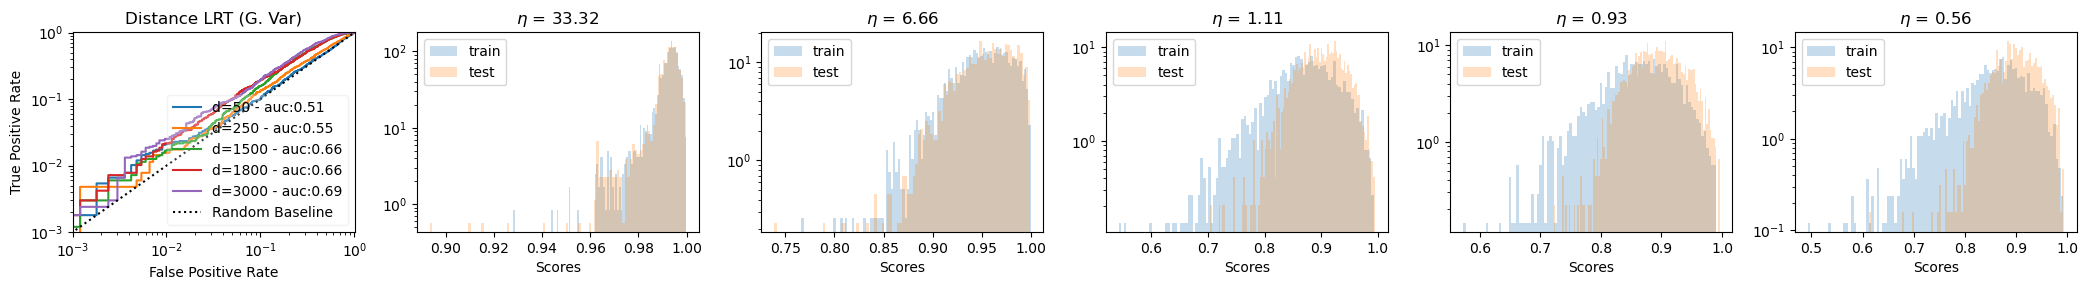

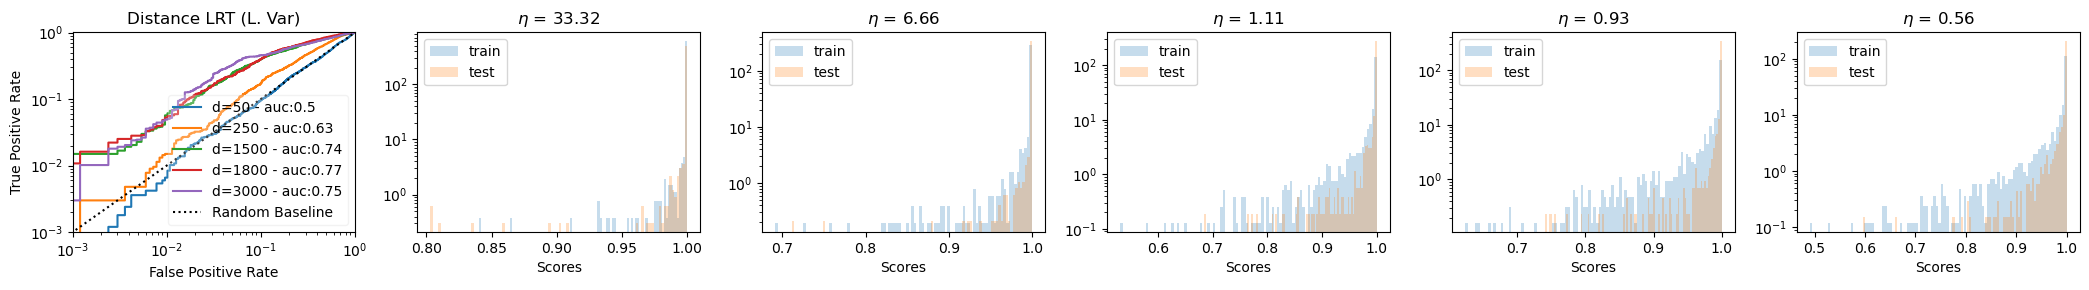

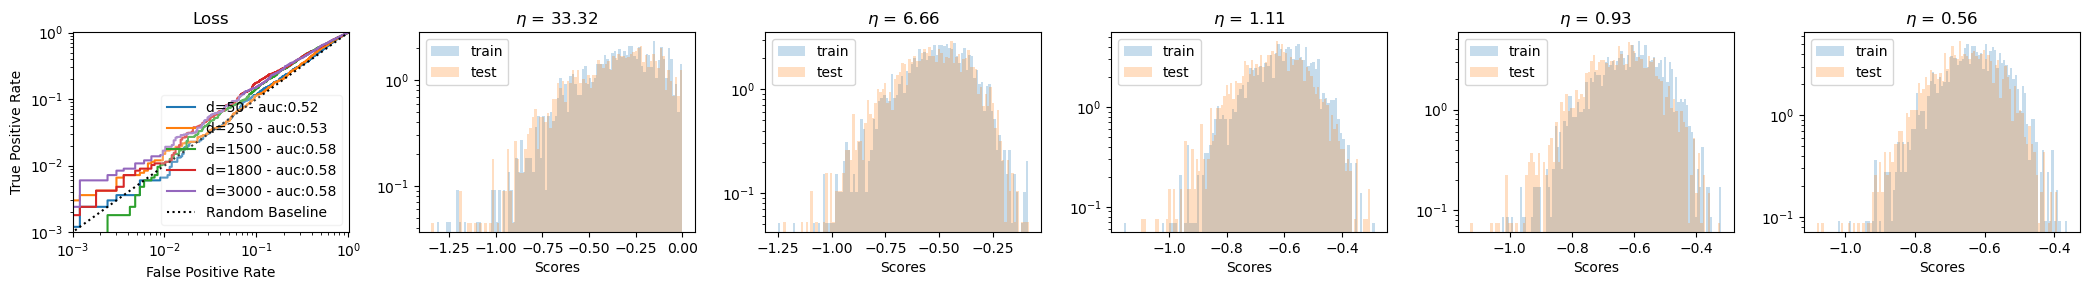

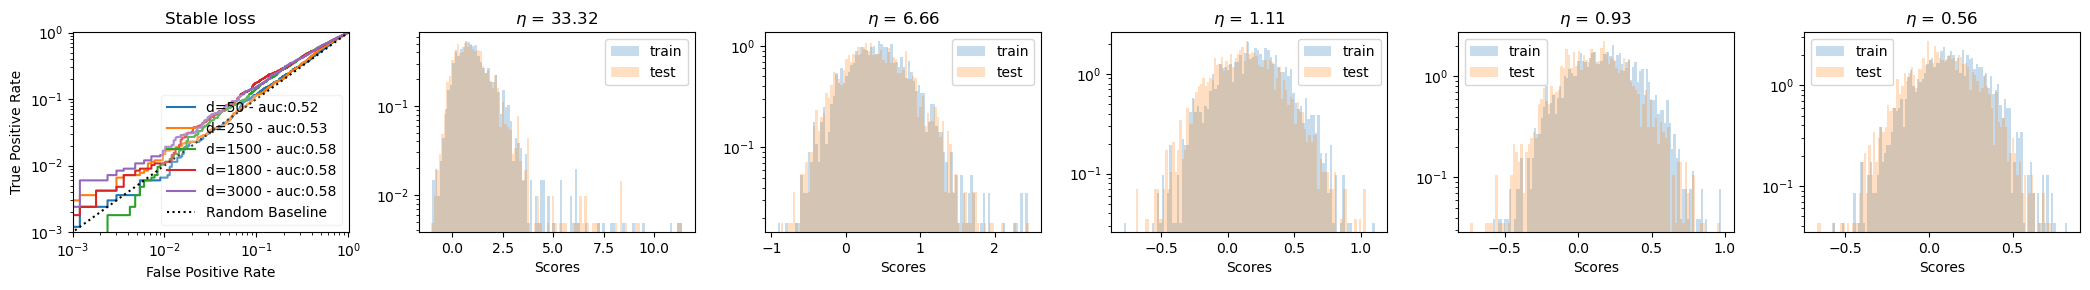

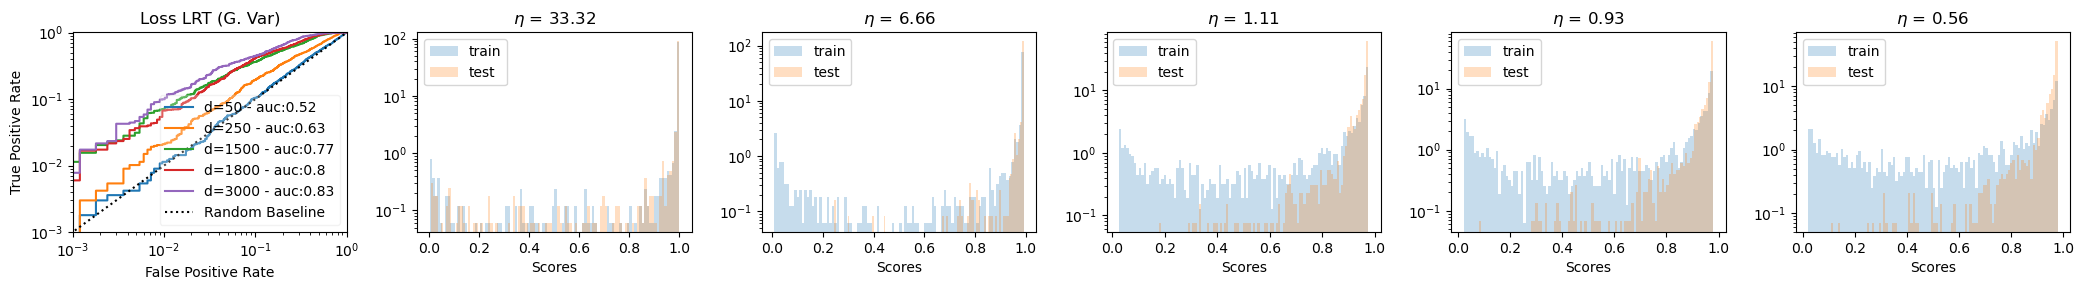

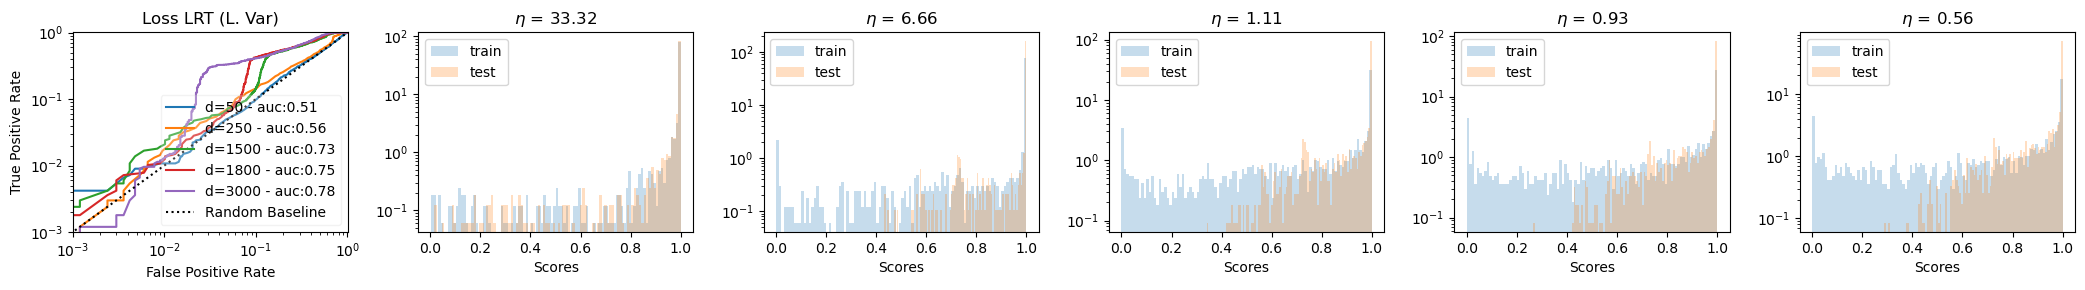

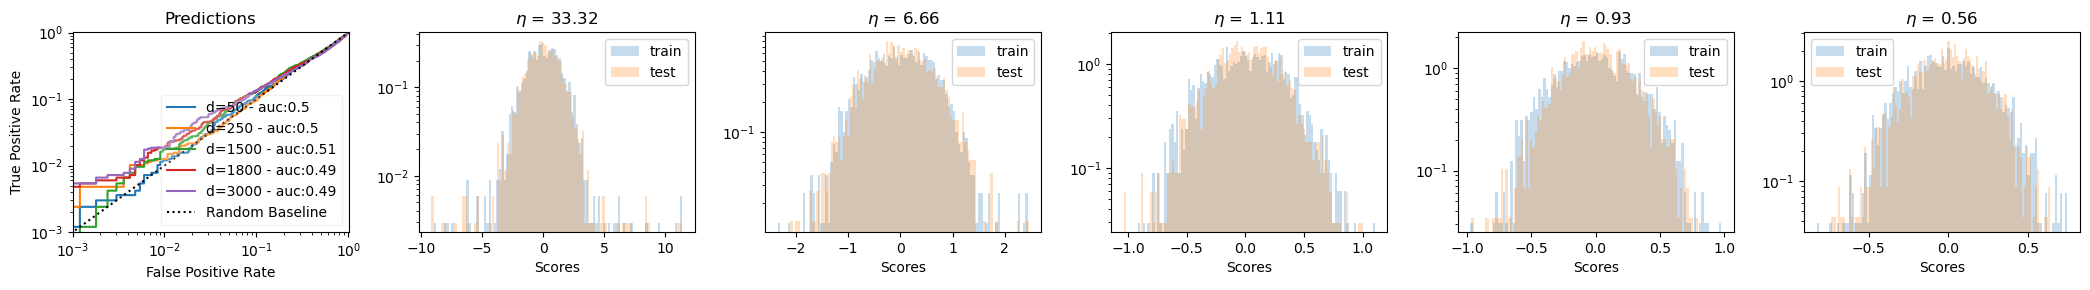

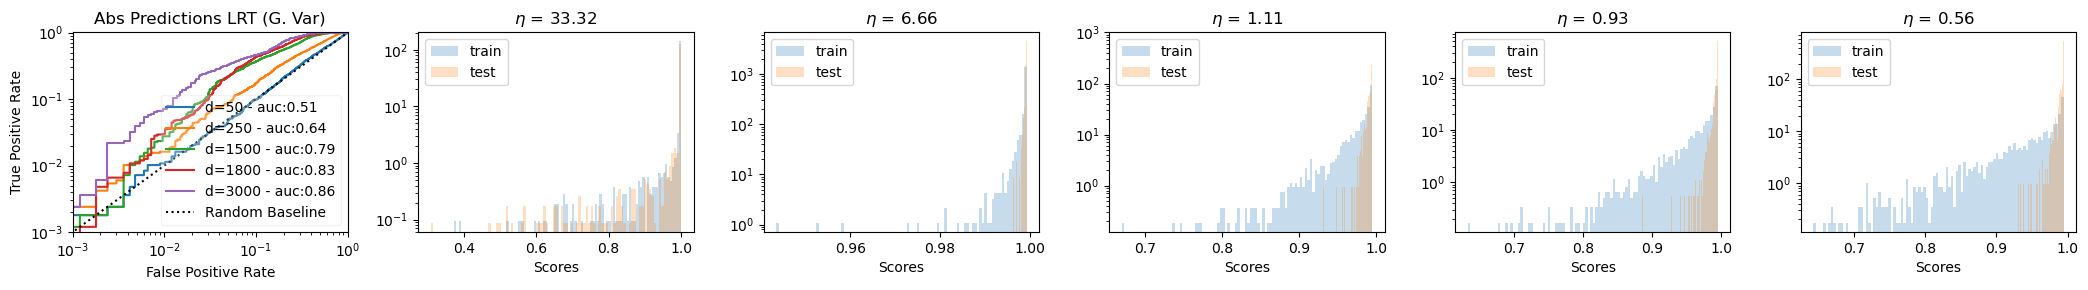

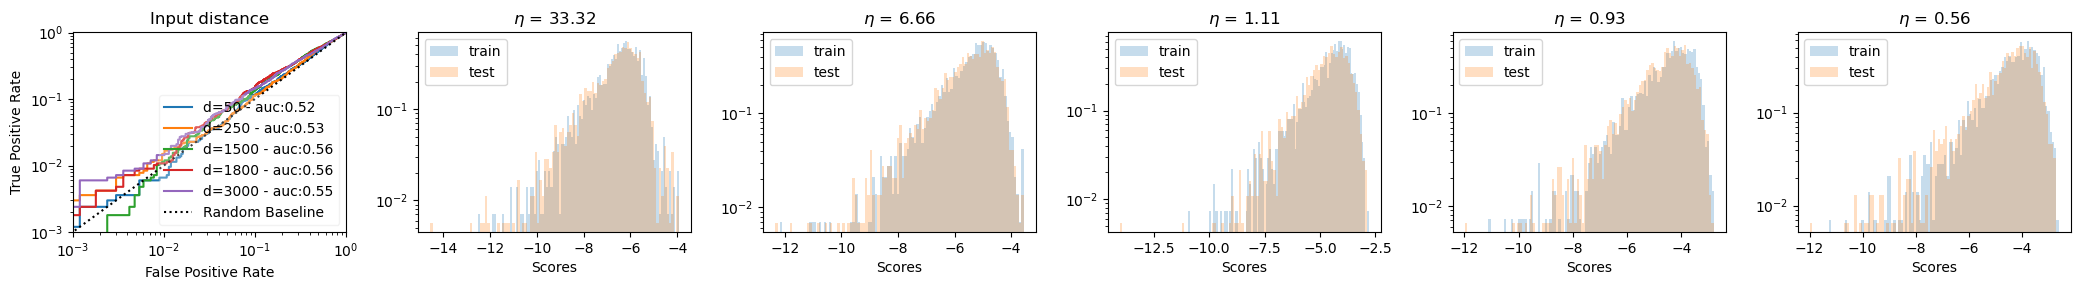

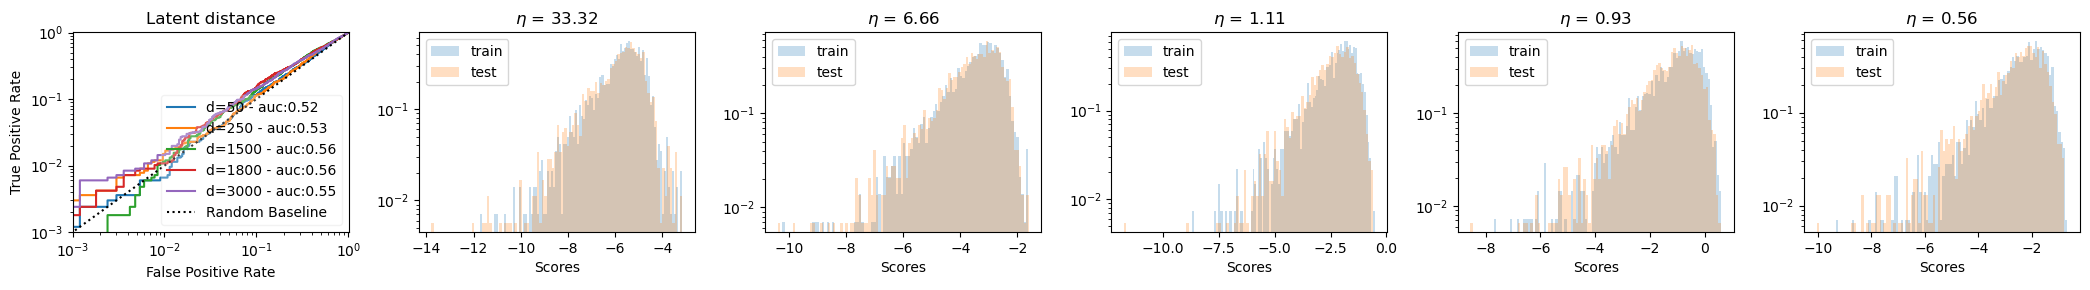

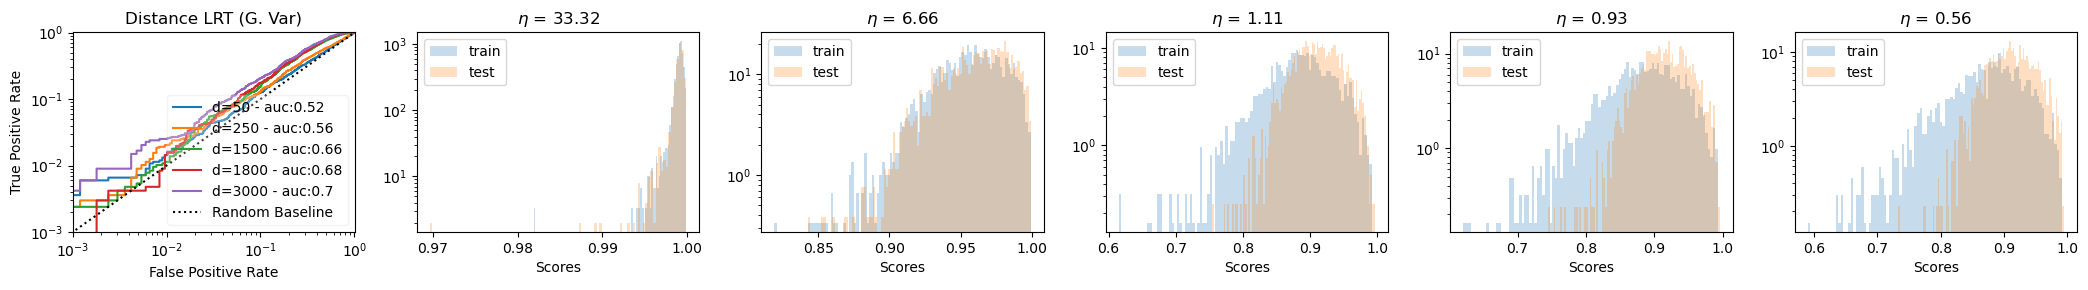

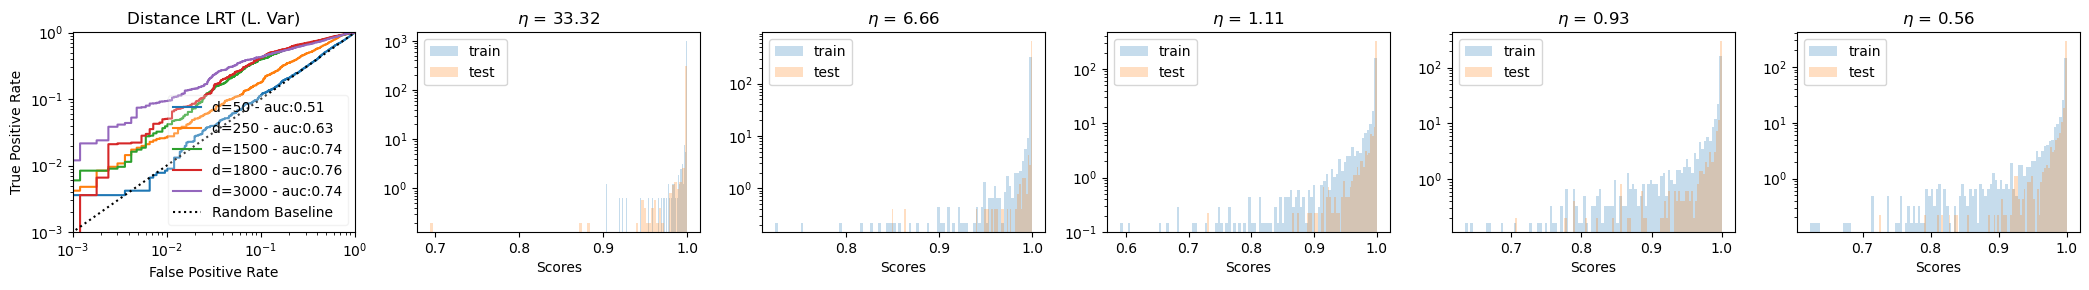

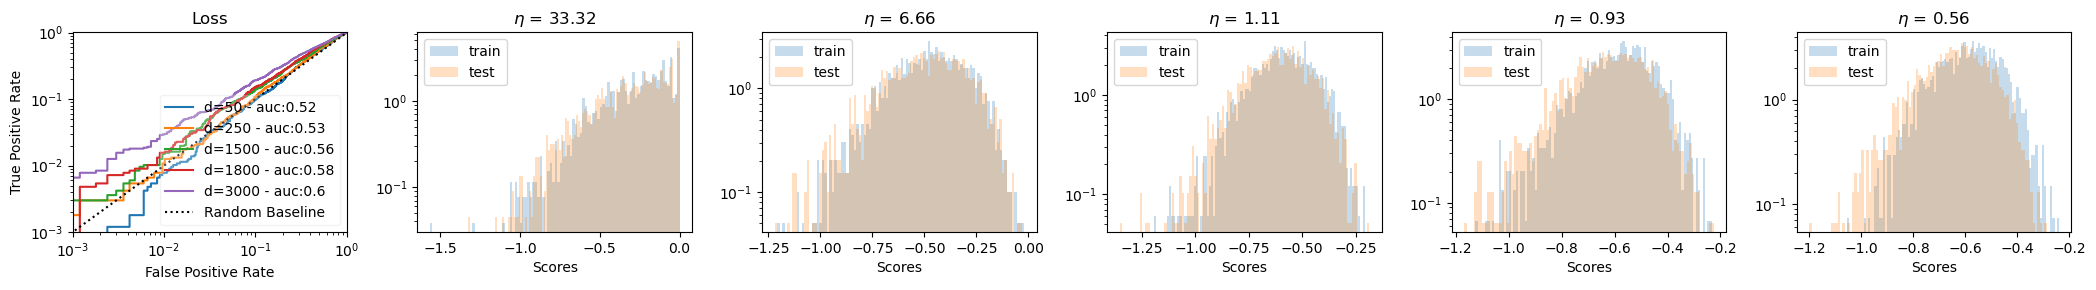

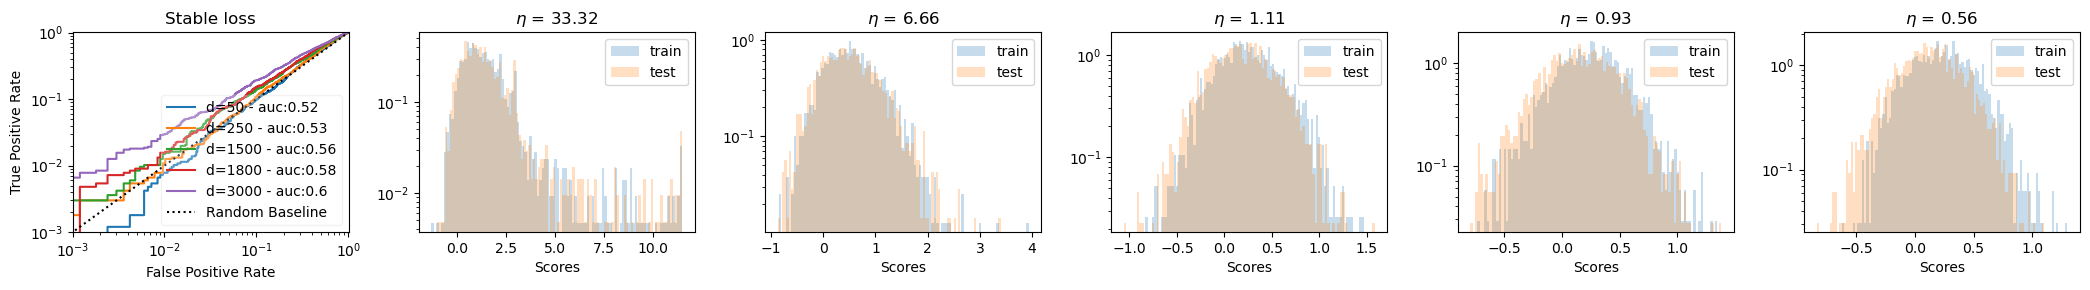

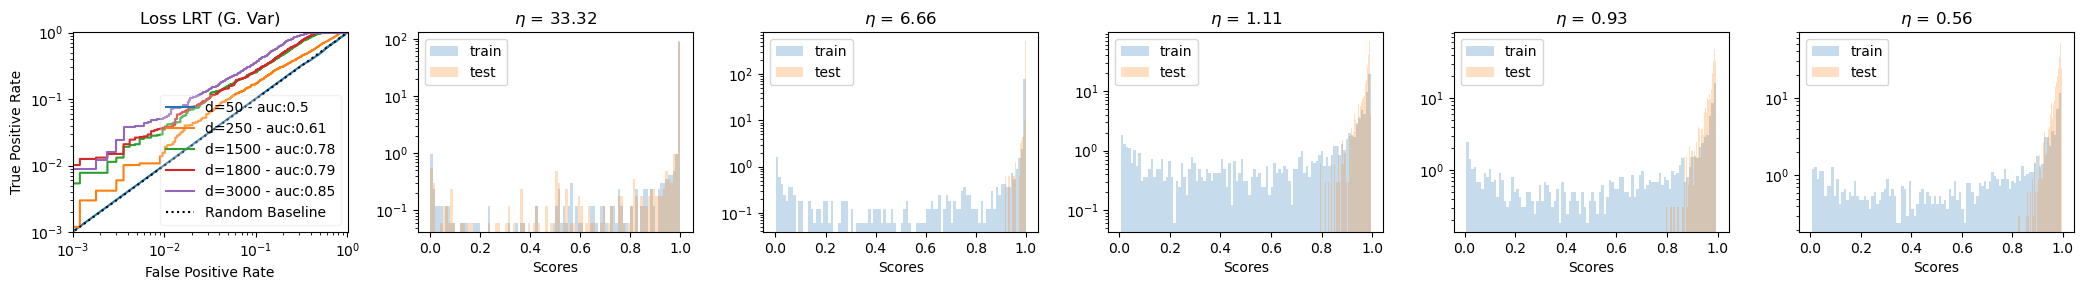

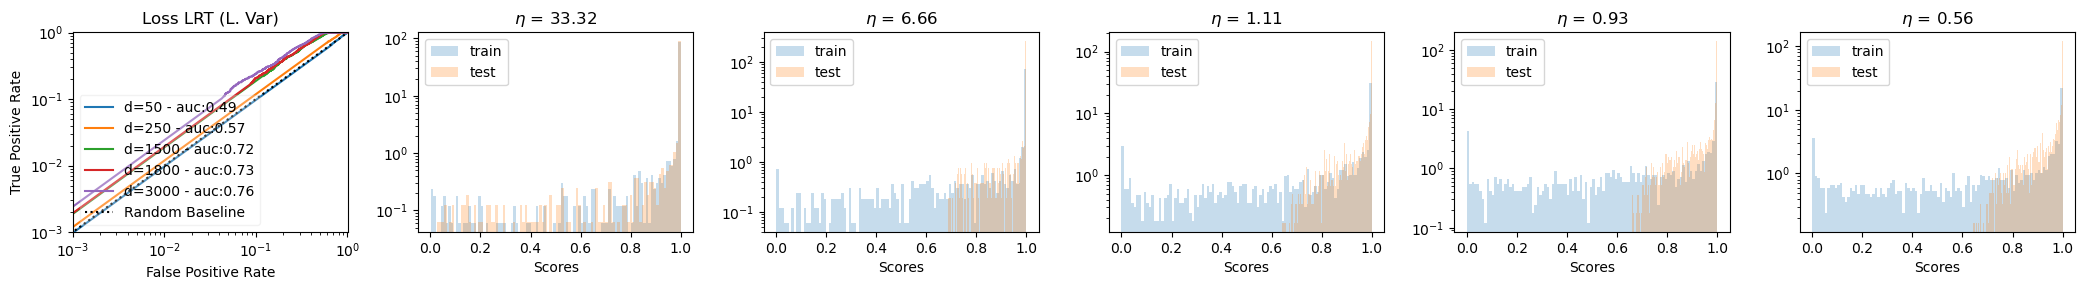

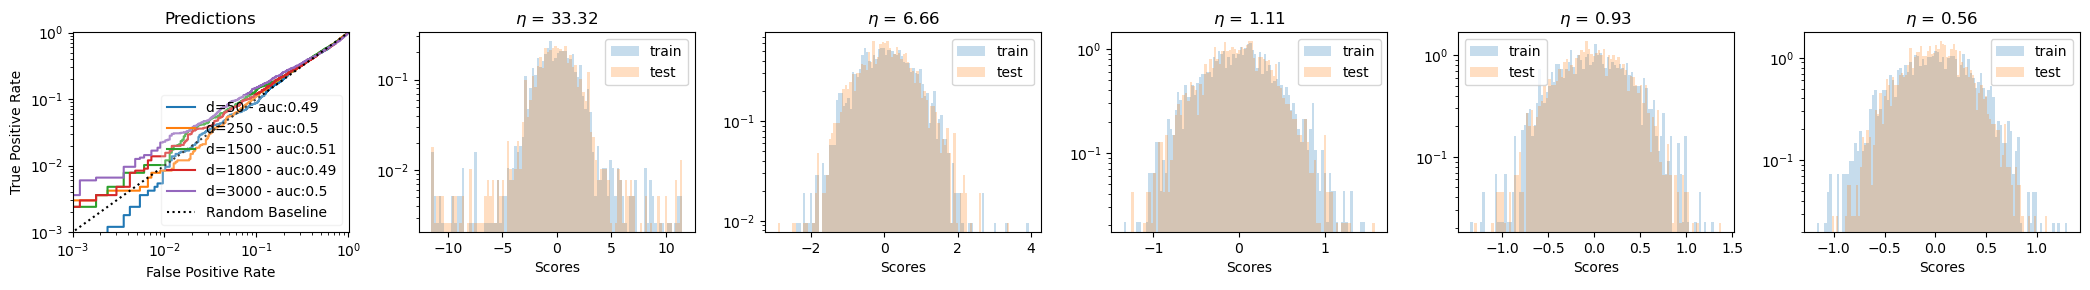

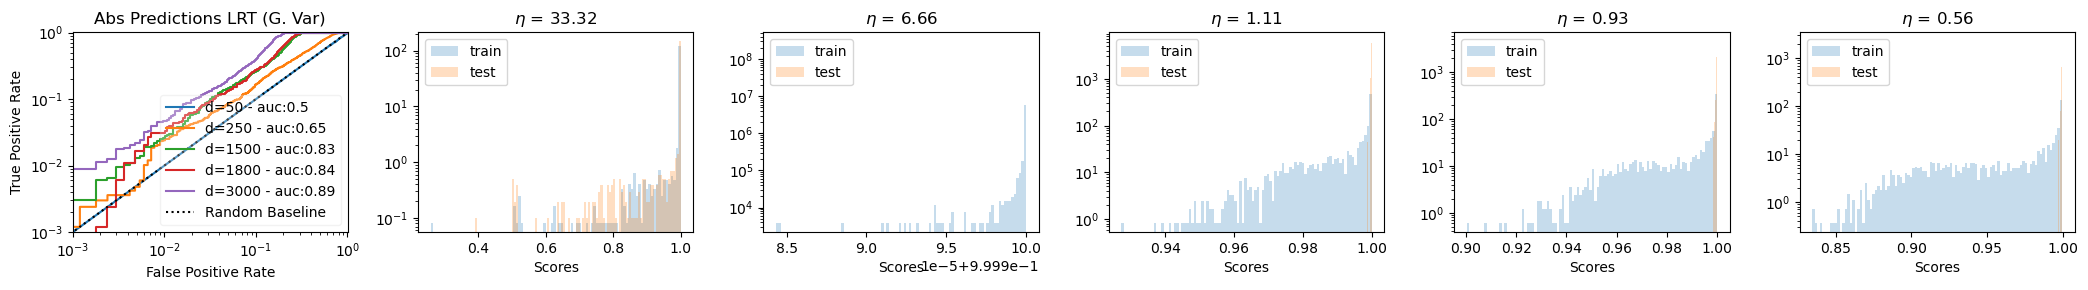

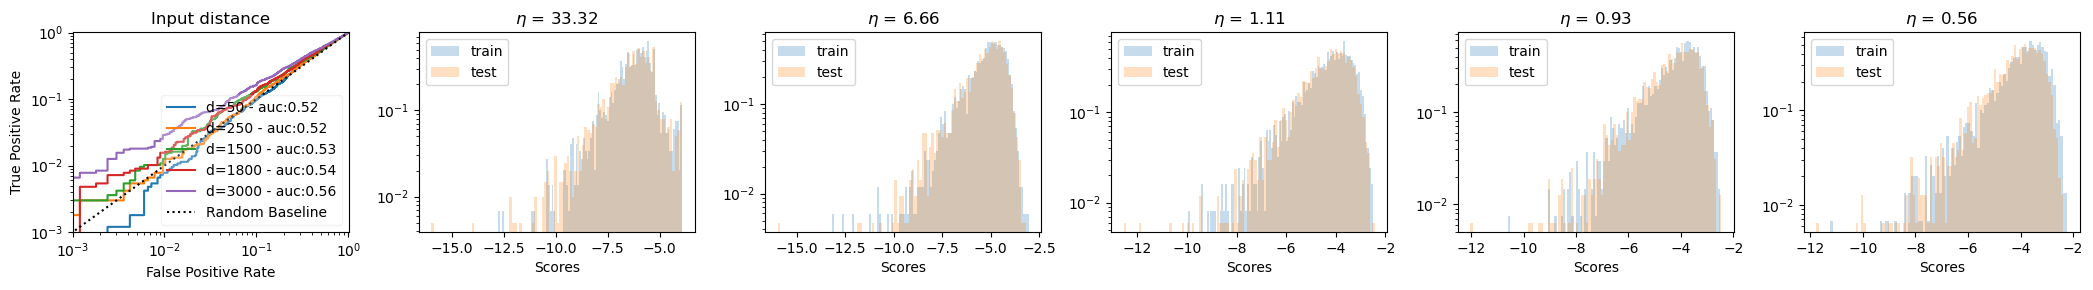

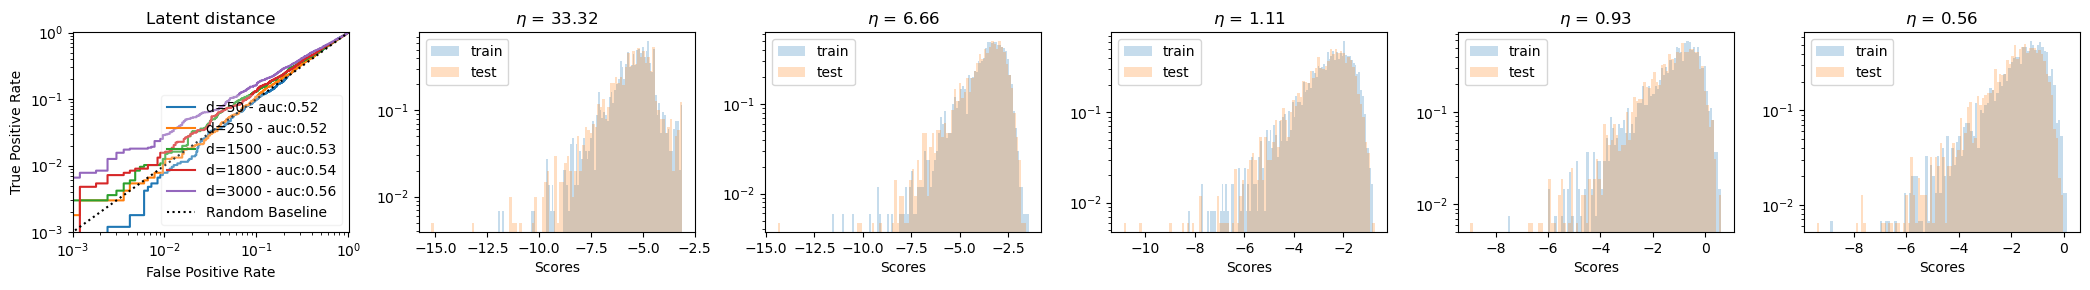

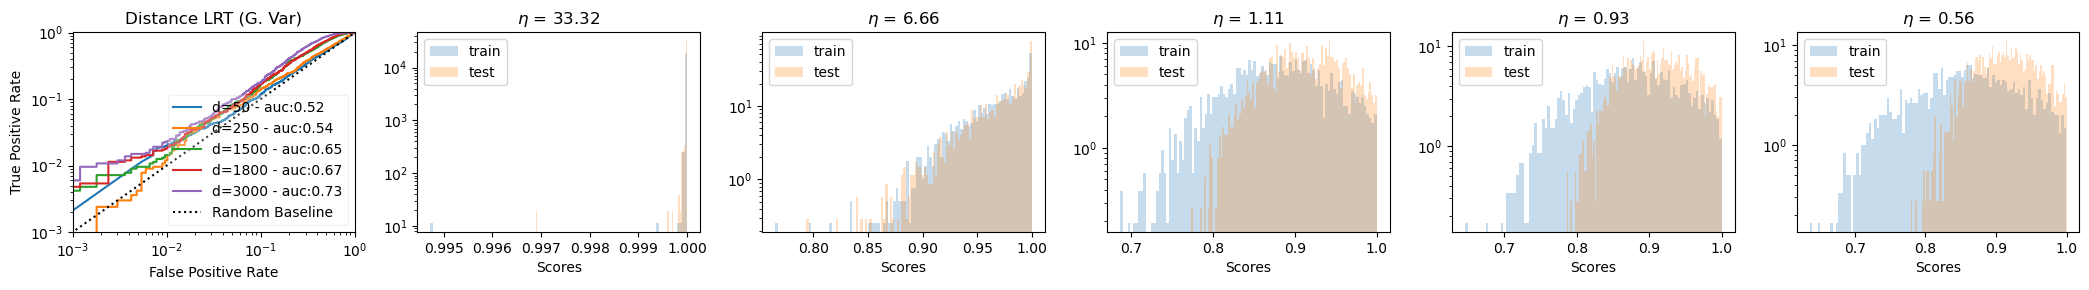

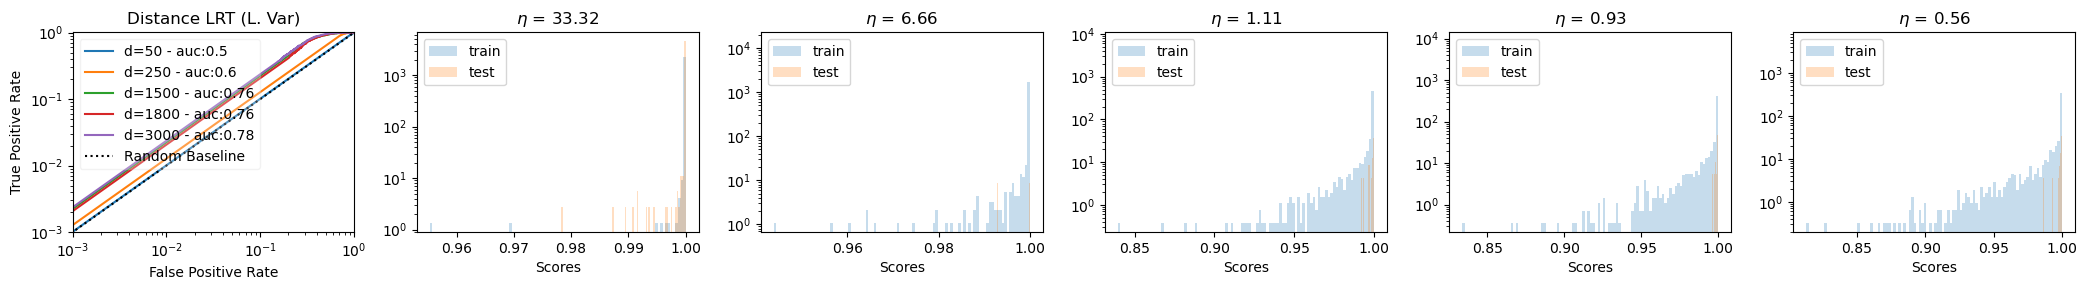

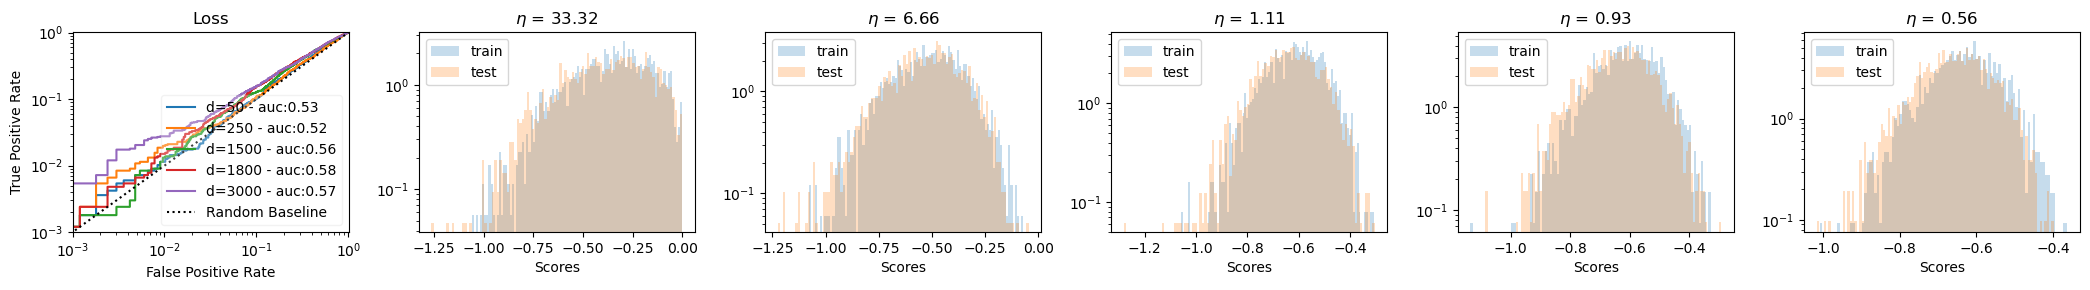

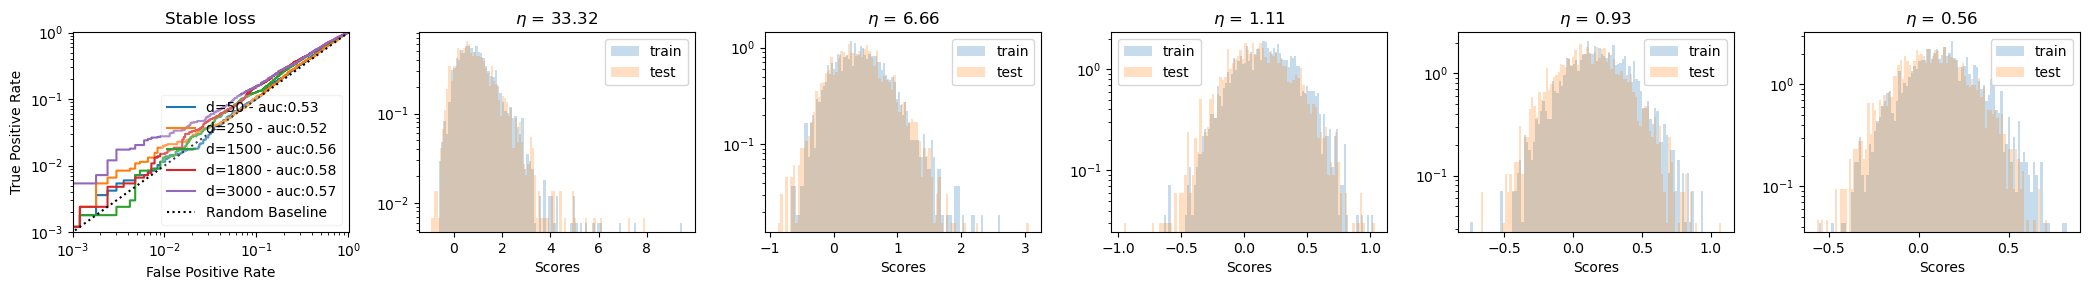

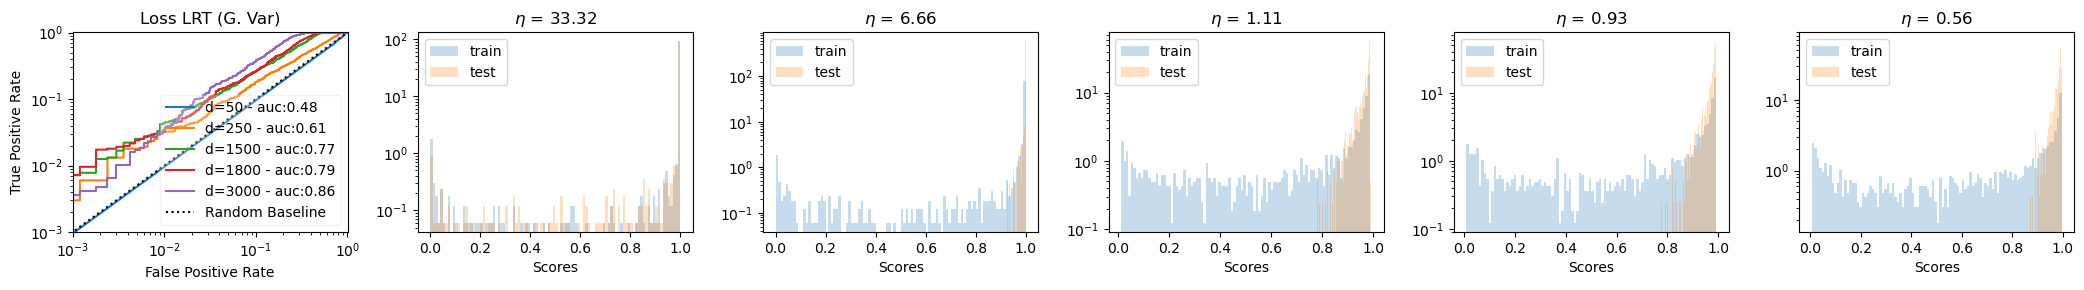

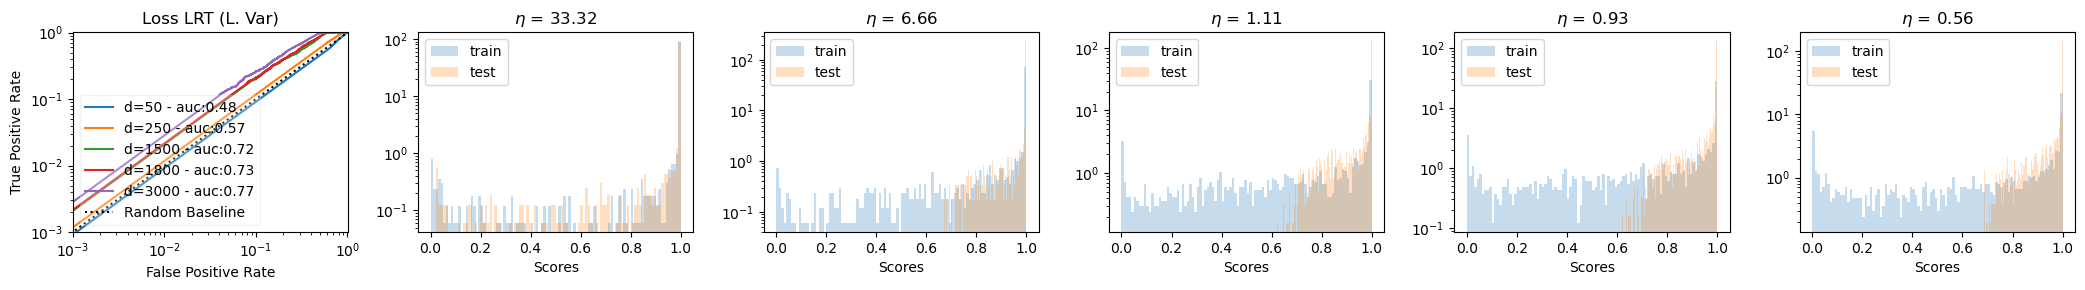

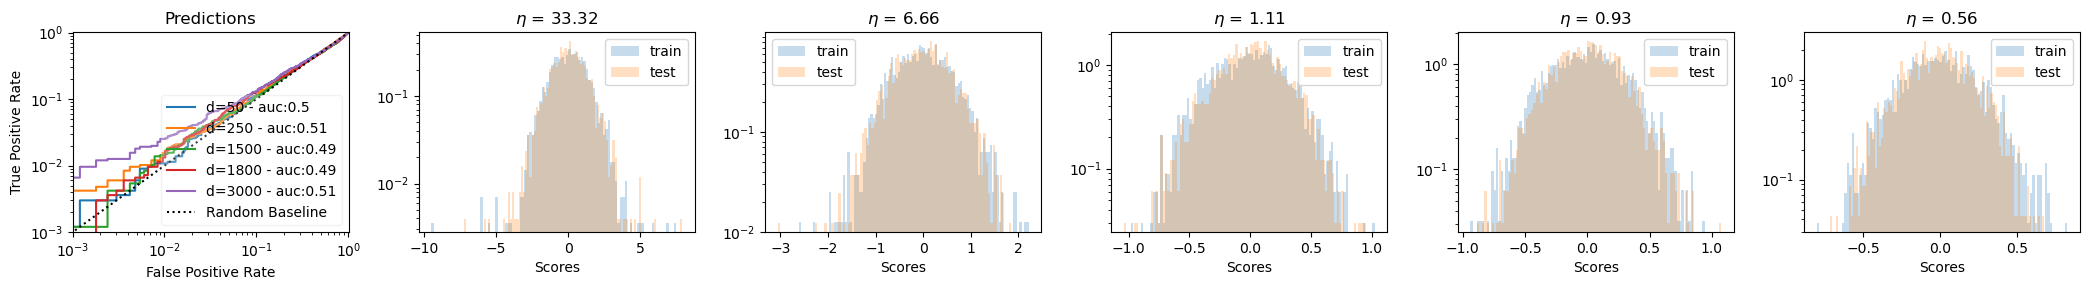

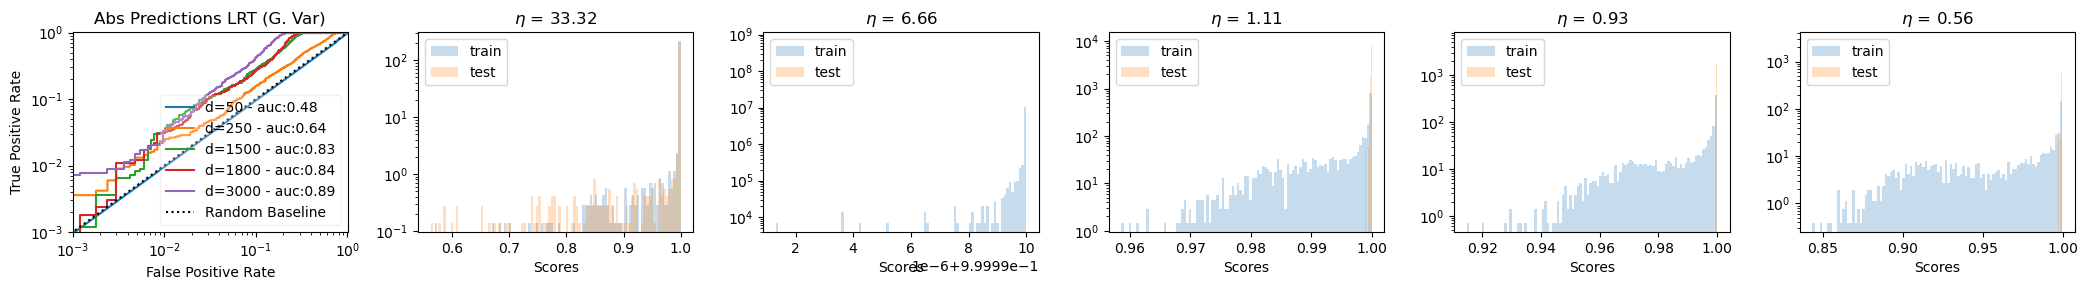

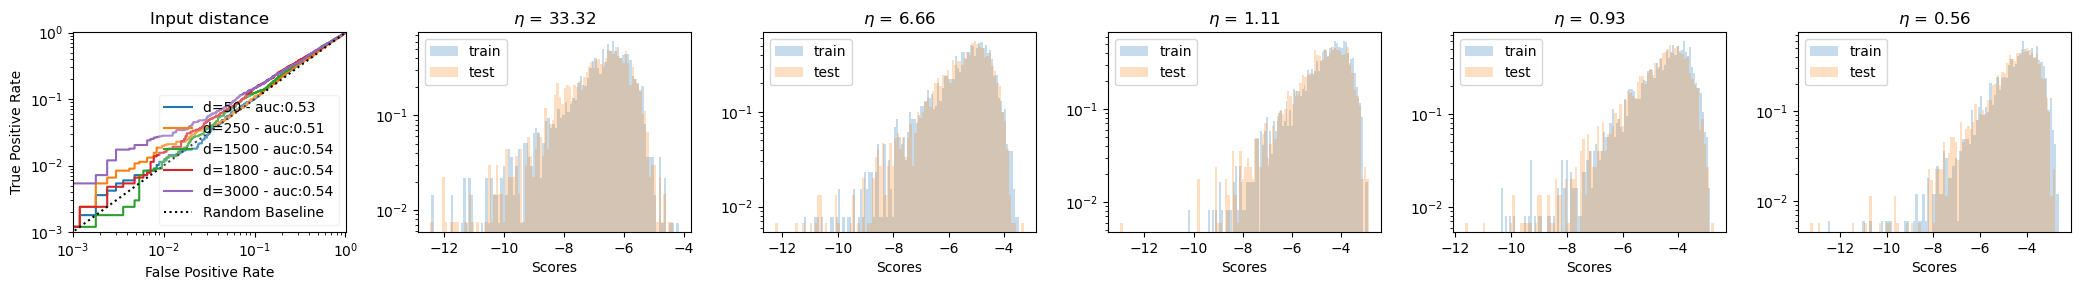

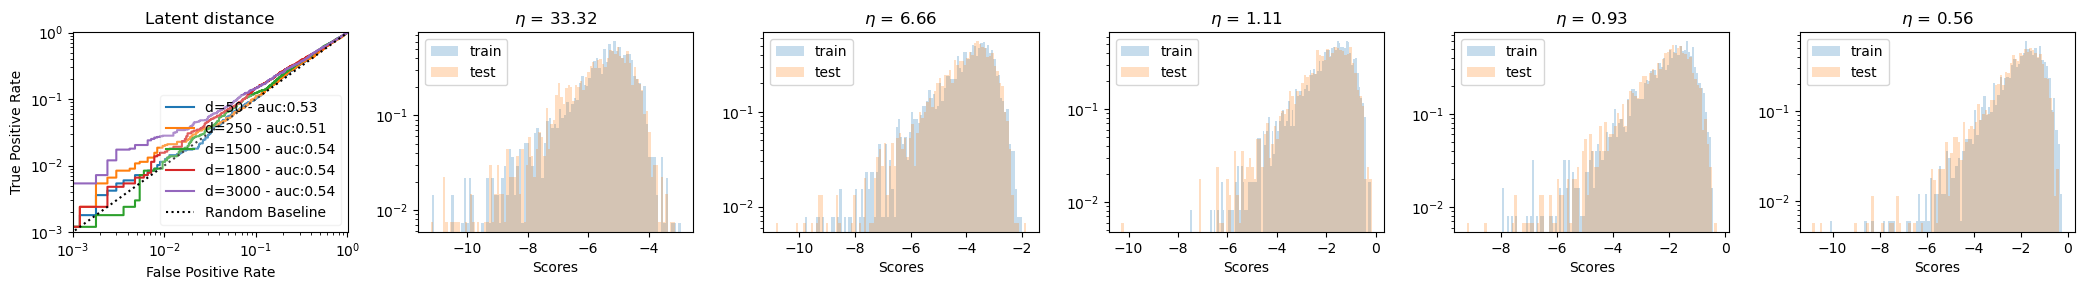

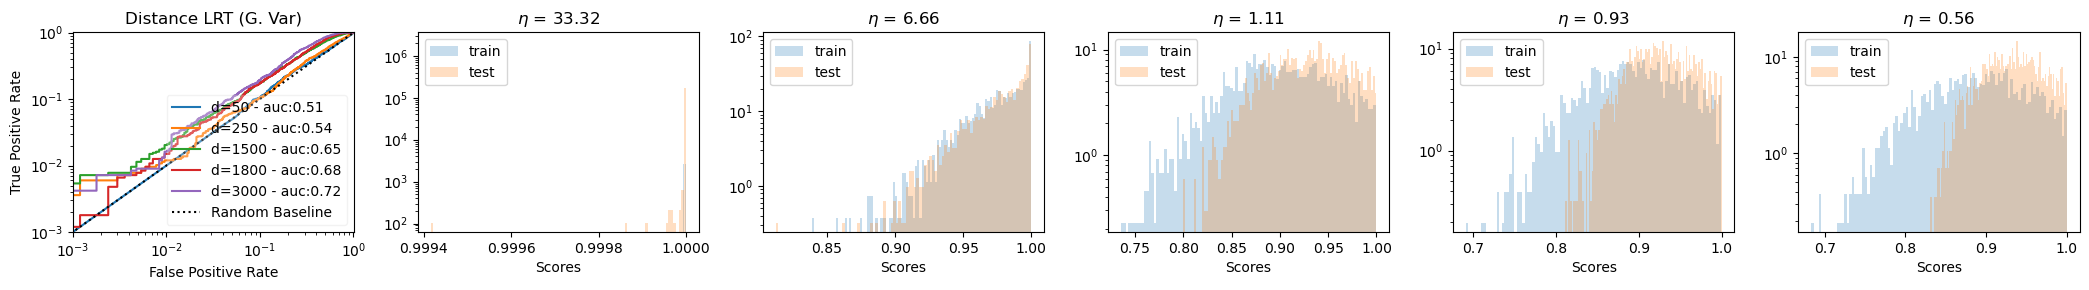

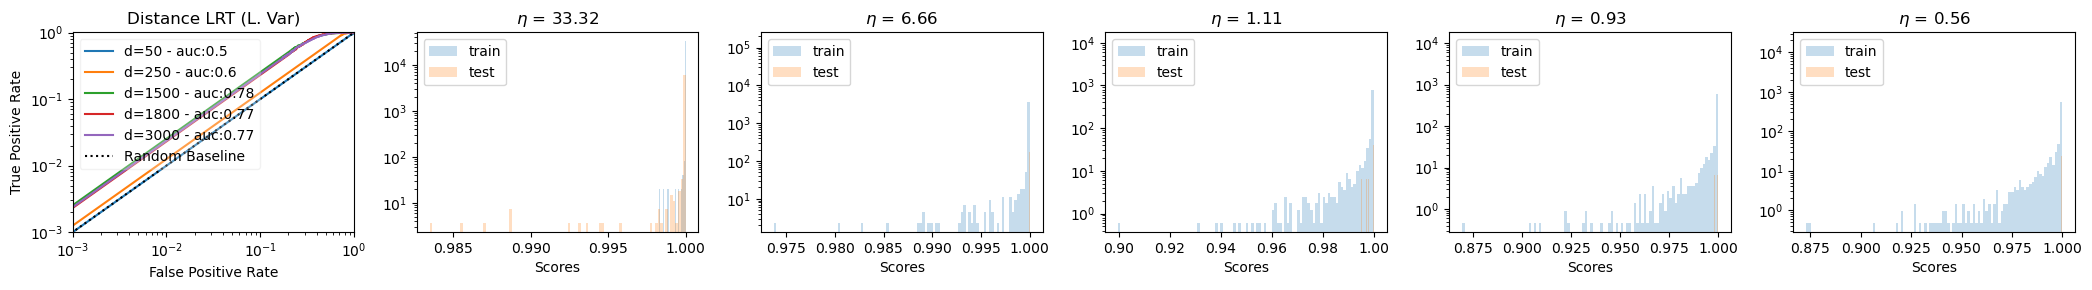

In [21]:
# SETTING -> SHADOW MODELS / ENSEMBLE MODELS 
# 1): 5 shadow models, 250 n_ens - ratio: 5 / 250 = 1 / 25
# 2): 250 shadow models, 5 n_ens - ratio: 250 / 5 = 50
# 3): 5 shadow models, 5 n_ens - ratio: 5 / 5 = 1
shadows = [5, 100]
ens = [20, 30]
for m in shadows:
    for n in ens:
        print(f'GENERATE RESULTS FOR: {m} SHADOW MODELS & {n} ENSEMBLE MODELS')
        params['n_shadow_models'] = m
        params['n_splits'] = params['n_ensemble'] = n
        scores = experiment(params, synth_gauss)
        plots(scores['losses_train'], scores['losses_test'], synth_gauss, params, title='Loss')
        plots(scores['stable_losses_train'], scores['stable_losses_test'], synth_gauss, params, title='Stable loss')
        plots(scores['losses_lrt_train_global'], scores['losses_lrt_test_global'], synth_gauss, params, title='Loss LRT (G. Var)', label=0)
        plots(scores['losses_lrt_train_local'], scores['losses_lrt_test_local'], synth_gauss, params, title='Loss LRT (L. Var)', label=0)
        plots(scores['preds_train'], scores['preds_test'], synth_gauss, params, title='Predictions')
        plots(scores['preds_lrt_train_global'], scores['preds_lrt_test_global'], synth_gauss, params, title='Abs Predictions LRT (G. Var)', label=0)
        
        plots(scores['dists_train'], scores['dists_test'], synth_gauss, params, title='Input distance')
        plots(scores['dists_latent_train'], scores['dists_latent_test'], synth_gauss, params, title='Latent distance')
        plots(scores['dists_lrt_train_global'], scores['dists_lrt_test_global'], synth_gauss, params, title='Distance LRT (G. Var)', label=0)
        plots(scores['dists_lrt_train_local'], scores['dists_lrt_test_local'], synth_gauss, params, title='Distance LRT (L. Var)', label=0)
        #plots(scores['dists_train_quantile'], scores['dists_test_quantile'], synth_gauss, params, title='Distance Quantile', label=1)
        